### Preprocessing

In [ ]:
# Imports
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load sms-spam data
data = pd.read_csv('sample_data/spam.csv', encoding = 'latin-1')
data = data.iloc[:, :2]
data.columns = ['label', 'text']

In [ ]:
# Preprocessing
data['label'] = data['label'].apply(lambda x: 1 if x == 'spam' else 0)

In [ ]:
# Split into 2 sets: Count and tf-idf
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

### Distribution and Description

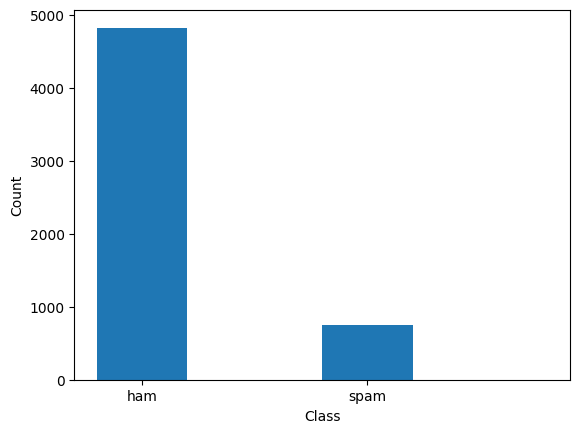

In [ ]:

# Plot the distribution of the target classes
plt.hist(data['label'], bins=2, width=.2, align='right')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([.35, .85], ['ham', 'spam'])
plt.show()

The [dataset](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset) contains over 5000 SMS messages which are either spam or "ham" as shown in the distribution above. Messages that are "ham" are simply not spam. The model should be able to predict which messages are spam and which are "ham" or not spam based on the message. It should be able to analyze frequent words that appear across spam messages and use that to identify new spam messages.

### Sequential Model

In [ ]:

# Tokenize and pad the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text'])
vocab_size = len(tokenizer.word_index) + 1

# Train and test
X_train = tokenizer.texts_to_sequences(train_data['text'])
X_test = tokenizer.texts_to_sequences(test_data['text'])

max_length = max(len(x) for x in X_train)
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

y_train = train_data['label'].values
y_test = test_data['label'].values

# Define the sequential model
model = Sequential([
    Embedding(vocab_size, 16, input_length=max_length),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile and train the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, validation_split=0.1)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy}")


Epoch 1/20
126/126 [==============================] - 2s 5ms/step - loss: 0.5303 - accuracy: 0.8659 - val_loss: 0.3954 - val_accuracy: 0.8565
Epoch 2/20
126/126 [==============================] - 0s 4ms/step - loss: 0.3580 - accuracy: 0.8671 - val_loss: 0.3703 - val_accuracy: 0.8565
Epoch 3/20
126/126 [==============================] - 1s 4ms/step - loss: 0.3354 - accuracy: 0.8671 - val_loss: 0.3449 - val_accuracy: 0.8565
Epoch 4/20
126/126 [==============================] - 0s 4ms/step - loss: 0.2971 - accuracy: 0.8671 - val_loss: 0.2936 - val_accuracy: 0.8565
Epoch 5/20
126/126 [==============================] - 1s 4ms/step - loss: 0.2265 - accuracy: 0.8838 - val_loss: 0.2109 - val_accuracy: 0.9081
Epoch 6/20
126/126 [==============================] - 0s 4ms/step - loss: 0.1451 - accuracy: 0.9484 - val_loss: 0.1441 - val_accuracy: 0.9574
Epoch 7/20
126/126 [==============================] - 1s 4ms/step - loss: 0.0904 - accuracy: 0.9766 - val_loss: 0.1098 - val_accuracy: 0.9641
Epoch 

### RNN

In [ ]:

# Define the RNN model
model_rnn = Sequential([
    Embedding(vocab_size, 16, input_length=max_length),
    SimpleRNN(32),
    Dense(1, activation='sigmoid')
])

# Modify learning rate
optimizer = Adam(learning_rate=.0001)

# Compile and train the model
model_rnn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_rnn.fit(X_train, y_train, epochs=20, validation_split=0.1)

# Evaluate the model on the test data
loss, accuracy = model_rnn.evaluate(X_test, y_test)
print(f"Test accuracy (RNN): {accuracy}")

Epoch 1/20
126/126 [==============================] - 6s 32ms/step - loss: 0.5063 - accuracy: 0.8340 - val_loss: 0.4236 - val_accuracy: 0.8565
Epoch 2/20
126/126 [==============================] - 4s 30ms/step - loss: 0.3983 - accuracy: 0.8671 - val_loss: 0.4114 - val_accuracy: 0.8565
Epoch 3/20
126/126 [==============================] - 5s 43ms/step - loss: 0.3925 - accuracy: 0.8671 - val_loss: 0.4114 - val_accuracy: 0.8565
Epoch 4/20
126/126 [==============================] - 4s 30ms/step - loss: 0.3920 - accuracy: 0.8671 - val_loss: 0.4115 - val_accuracy: 0.8565
Epoch 5/20
126/126 [==============================] - 4s 29ms/step - loss: 0.3920 - accuracy: 0.8671 - val_loss: 0.4119 - val_accuracy: 0.8565
Epoch 6/20
126/126 [==============================] - 5s 41ms/step - loss: 0.3920 - accuracy: 0.8671 - val_loss: 0.4118 - val_accuracy: 0.8565
Epoch 7/20
126/126 [==============================] - 4s 29ms/step - loss: 0.3919 - accuracy: 0.8671 - val_loss: 0.4116 - val_accuracy: 0.8565

### GloVe embedding

In [ ]:
# Load 100D GloVe embeddings
glove_file_path = 'sample_data/glove.6B.100d.txt'
embeddings_index = {}
with open(glove_file_path, encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create the embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
# Define the model with GloVe embeddings
model_glove = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False),
    SimpleRNN(32),
    Dense(1, activation='sigmoid')
])

# Compile and train the model
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_glove.fit(X_train, y_train, epochs=20, validation_split=0.1)

# Evaluate the model on the test data
loss, accuracy = model_glove.evaluate(X_test, y_test)
print(f"Test accuracy (GloVe): {accuracy}")


Epoch 1/20
126/126 [==============================] - 5s 28ms/step - loss: 0.4335 - accuracy: 0.8070 - val_loss: 0.3601 - val_accuracy: 0.8565
Epoch 2/20
126/126 [==============================] - 5s 38ms/step - loss: 0.3483 - accuracy: 0.8671 - val_loss: 0.3502 - val_accuracy: 0.8565
Epoch 3/20
126/126 [==============================] - 3s 25ms/step - loss: 0.3214 - accuracy: 0.8621 - val_loss: 0.3542 - val_accuracy: 0.8565
Epoch 4/20
126/126 [==============================] - 3s 25ms/step - loss: 0.3053 - accuracy: 0.8659 - val_loss: 0.4405 - val_accuracy: 0.8565
Epoch 5/20
126/126 [==============================] - 3s 25ms/step - loss: 0.3933 - accuracy: 0.8669 - val_loss: 0.4178 - val_accuracy: 0.8565
Epoch 6/20
126/126 [==============================] - 5s 37ms/step - loss: 0.3900 - accuracy: 0.8669 - val_loss: 0.4011 - val_accuracy: 0.8565
Epoch 7/20
126/126 [==============================] - 3s 25ms/step - loss: 0.3849 - accuracy: 0.8669 - val_loss: 0.3994 - val_accuracy: 0.8565

## Results

In [ ]:
# Sequential
_, seq_accuracy = model.evaluate(X_test, y_test, verbose=0)

# SimpleRNN
_, rnn_accuracy = model_rnn.evaluate(X_test, y_test, verbose=0)

# SimpleRNN with GloVe
_, glove_accuracy = model_glove.evaluate(X_test, y_test, verbose=0)

# Print the accuracy scores for each model
print(f"Test accuracy (Sequential): {seq_accuracy:.2f}")
print(f"Test accuracy (SimpleRNN): {rnn_accuracy:.2f}")
print(f"Test accuracy (SimpleRNN with GloVe embeddings): {glove_accuracy:.2f}")

Test accuracy (Sequential): 0.98
Test accuracy (SimpleRNN): 0.87
Test accuracy (SimpleRNN with GloVe embeddings): 0.86


## Summary & Analysis
The highest performing deep learning model was actually the sequential model, which is the most simple implementation. It makes sense that it works better because this dataset is very simple and a very simple instance of classification. 
### RNN
The SimpleRNN capped at 86.7% with no special embeddings. This was lower than the sequential model, but it is still high and it is able to reach this accuracy after very few epochs.
### Embeddings
I implemented GloVe embeddings, a powerful word embedding model. It actually reduced the SimpleRNN's learning capabilities, making it take more epochs in order to reach the same max accuracy. 